# XGB test


In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [18]:
import pandas as pd

import seaborn as sns

from math import log

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from xgboost import XGBRegressor
import shap


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from plots2.fns import (
    # standard_layout,
    # corner_annotations_colwise,
    # corner_annotations_rowwise,
    # get_text_annotation,
    get_corner_annotations,
    get_corner_annotations_custom_labels,
    # get_corner_annotations_explicit
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
    SHAP_BLUE
)

from poly2.utils import trait_vec, gamma_dist, object_dump, object_load
from poly2.shap import get_shap_values_cumulative
# from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
# from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote

In [3]:
df = pd.read_csv('../outputs/combined/scan_all.csv')

df.head()

,run,year,best_dose,n_pos_diff,in_0p0_0p1,in_0p1_0p2,in_0p2_0p3,in_0p3_0p4,in_0p4_0p5,in_0p5_0p6,...,in_0p8_0p9,in_0p9_1p0,mu,b,asymptote,dec_rate_multiplier,m_prop_multiplier,m_scale_multiplier,ME_var,ME_mean
0,0,1,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
1,0,2,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
2,0,3,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
3,0,4,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
4,0,5,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241


In [14]:
X = (
    # df_filt
    df
    .drop([
        'best_dose',
        'n_pos_diff',
        'ME_var',
        # 'ME_mean',
        # 'yld',
        # 'cum_yld',
    ], axis=1)
    .filter(regex='^((?!in_0).)*$')
    .rename(columns = {
        'dec_rate_multiplier': 'dec_rate',
        'm_prop_multiplier': 'm_prop',
        'm_scale_multiplier': 'm_scale',
        'asymptote': 'asymp',
    })
    
#     .drop('ME_mean', axis=1)
#     .assign(a = lambda x: x.b*x.mu)
#     .assign(nu = lambda x: (x.b)**(x.a) / (1 + x.b)**(x.a))
#     .assign(ME_mean = lambda x: 1 - x.asymp + x.asymp * x.nu)
    
#     .drop(['a', 'nu'], axis=1)
)

# y = df_filt.loc[:, ['run', 'best_dose']]
y = df.loc[:, ['run', 'best_dose']]

X.head()

,run,year,mu,b,asymp,dec_rate,m_prop,m_scale,ME_mean
0,0,1,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
1,0,2,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
2,0,3,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
3,0,4,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
4,0,5,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241


In [15]:
# reset index? Might help with Int64Index XGB warning
X_cv = X.loc[lambda x: (x.run<8000)].drop('run', axis=1)
y_cv = y.loc[lambda x: (x.run<8000)].drop('run', axis=1)

X_test = X.loc[lambda x: (x.run>=8000)].drop('run', axis=1)
y_test = np.array(y.loc[lambda x: (x.run>=8000)].drop('run', axis=1))

In [16]:
hyperparams = (
    pd.read_csv('../outputs/best_XGB_hyperparams.csv')
    .iloc[0]
    .to_dict()
)

hyperparams['max_depth'] = int(hyperparams['max_depth'])
hyperparams['n_estimators'] = int(hyperparams['n_estimators'])

hyperparams['objective'] = 'reg:pseudohubererror'

hyperparams

{'max_depth': 10,
 'n_estimators': 853,
 'learning_rate': 0.0182387397607204,
 'subsample': 0.721624617726085,
 'colsample_bytree': 0.943486029986996,
 'objective': 'reg:pseudohubererror'}

In [17]:
%%time

rmse_list = []
        
kf = KFold(n_splits=10)

for train_ind, val_ind in tqdm(kf.split(X_cv)):

    X_tr = X_cv.iloc[train_ind]
    y_tr = y_cv.iloc[train_ind]

    X_v = X_cv.iloc[val_ind]
    y_v = y_cv.iloc[val_ind]
    
    train_runs = X.iloc[train_ind].run
    val_runs = X.iloc[val_ind].run

    print(f'ok? {sum(train_runs.isin(val_runs))==0}')

    y_tr = np.array(y_tr)
    y_v = np.array(y_v)

    model = XGBRegressor(
        **hyperparams,
    ).fit(X_tr, y_tr)

    y_p = model.predict(X_v)

    rmse = mean_squared_error(y_p, y_v, squared=False)

    rmse_list.append(rmse)

score = sum(rmse_list)/len(rmse_list)

score

ok? True


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


ok? True


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


ok? True


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


ok? True


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


ok? True


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


ok? True


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


ok? True


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


ok? True


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


ok? True


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


ok? True


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Wall time: 16min 6s


0.10888194232377864

Aiming to beat `0.110` (squared error, keep non-exact `ME_mean`)

- `0.1138`: using `reg:pseudohubererror` and dropping `ME_mean`.
- `0.1089`: using `reg:pseudohubererror` and keeping `ME_mean`.
- `XX`: using `reg:squarederror` and dropping `ME_mean`.
- `XX`: using `reg:squarederror` and using exact `ME_mean`.

<AxesSubplot:>

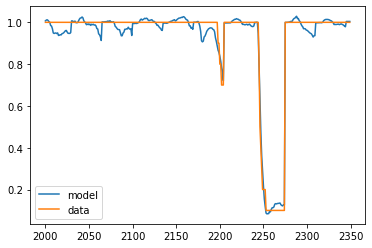

In [30]:
start = 2000
show = 350

(
    pd.DataFrame(dict(model=y_p, data=y_v[:, 0]))
    # .head(1000)
    .iloc[start:start+show]
    .plot()
)

In [157]:
%%time

best_model = XGBRegressor(**hyperparams).fit(X_cv, y_cv)

y_p = best_model.predict(X_test)

rmse = mean_squared_error(y_p, y_test, squared=False)

rmse

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Wall time: 1min 30s


0.050031964040011964

In [144]:
best_model.save_model('xgb_scan_all_no_ME_mean.json')

Shap vals took around `43.2s`

In [145]:
# %%time

# X_use = X_cv.head(1002)

# shap_values = get_shap_values_cumulative(X_use)

________________________________________________________________________________
[Memory] Calling poly2.shap.get_shap_values_cumulative...
get_shap_values_cumulative(      year         mu         b     asymp  dec_rate    m_prop   m_scale  \
0      1.0  17.879734  2.744068  0.602763  1.786355  0.703574  1.957890   
1      2.0  17.879734  2.744068  0.602763  1.786355  0.703574  1.957890   
2      3.0  17.879734  2.744068  0.602763  1.786355  0.703574  1.957890   
3      4.0  17.879734  2.744068  0.602763  1.786355  0.703574  1.957890   
4      5.0  17.879734  2.744068  0.602763  1.786355  0.703574  1.957890   
...    ...        ...       ...       ...       ...       ...       ...   
997   18.0   4.290742  3.649953  0.521037  0.478235  0.251185  0.108904   
998   19.0   4.290742  3.649953  0.521037  0.478235  0.251185  0.108904   
999   20.0   4.290742  3.649953  0.521037  0.478235  0.251185  0.108904   
1000  21.0   4.290742  3.649953  0.521037  0.478235  0.251185  0.108904   
1001  22.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


done
______________________________________get_shap_values_cumulative - 42.8s, 0.7min
Wall time: 42.9 s


In [146]:
fn = './shap_values_cumulative.pickle'

if True:
    object_dump(shap_values, fn)
else:
    shap_values = object_load(fn)

# Fig

In [147]:
WIDTH = 8
HEIGHT = 4

## A

Text(0.05, 0.9, 'A')

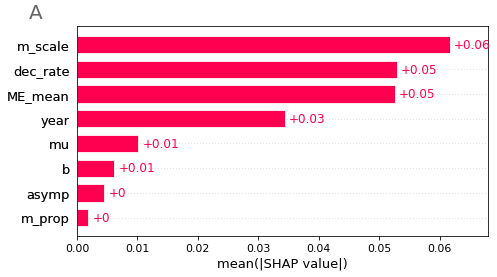

In [148]:
plt.close('all')

shap.plots.bar(shap_values, show=False)

f = plt.gcf()

ax = plt.gca()

f.set_figwidth(WIDTH)
f.set_figheight(HEIGHT)

f.patch.set_facecolor('white')


labels=[
    r'$M_s$',
    r'$M_d$',
    r'$\nu$',
    r'$Y$',
    r'$\mu$',
    r'$b$',
    r'$\omega$',
    r'$M_p$',
]*2

# ax.set_yticklabels(labels)


ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# ax.set_xlim([0, 0.15])

f.tight_layout(rect=[0.028, 0, 0.9, 0.92])

plt.annotate(
    'A',
    (0.05, 0.9),
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=20,
)

# f

In [149]:
f.savefig('../figures/to_combine/appc_fig5_1.jpg', dpi=300)

## B

Text(0.05, 0.9, 'B')

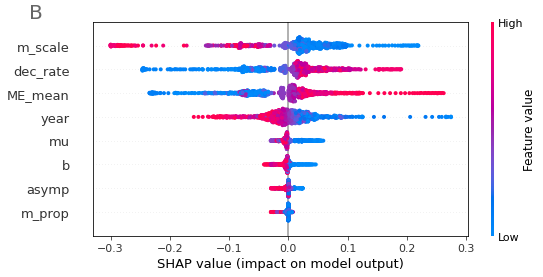

In [150]:
plt.close('all')

shap.plots.beeswarm(shap_values, plot_size=(WIDTH,HEIGHT), show=False)

f = plt.gcf()

ax = plt.gca()

f.patch.set_facecolor('white')


ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

labels=[
    r'$M_p$',
    r'$\omega$',
    r'$b$',
    r'$\mu$',
    r'$Y$',
    r'$\nu$',
    r'$M_d$',
    r'$M_s$',
]

# ax.set_yticklabels(labels)

f.tight_layout(rect=[0, 0, 1, 0.95])

plt.annotate(
    'B',
    (0.05, 0.9),
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=20,
)

In [151]:
f.savefig('../figures/to_combine/appc_fig5_2.jpg', dpi=300) # , bbox_inches="tight"

Run this in `cmd`:
```
cd Documents\Python\PhD\poly2\polygenic2\figures\to_combine
magick montage appc_fig5_[1-2].jpg -tile x2 -geometry 1000x450+2+20 appc_fig3.jpg
```